# FCS time-series dataset released by WFP 

In this notebook, we provide the time-series regarding the **Food Consumption Score (FCS)** indicator. The reference period of the time-series is continuously updated adding new files.

In [22]:
import pandas as pd
import numpy as np
import ntpath
import glob

In [23]:
# Add the python path to the folder containing useful packages.
import sys
sys.path.insert(0, "../../packages/")

In [24]:
from map_plot import draw_adminstratas
from TsIP.TsIP import TsIP

In [25]:
# Define the path where the results arising from this analysis will be saved.
PATH_TO_SAVE_DATA = "./output_timeseries/"

# YEM, NGA, SYR, BFA

The data of four countries are provided: *Yemen* (YEM), *Nigeria* (NGA), *Syria* (SYR) and *Burkina Faso* (BFA).

In [26]:
# Read the data released by wfp regarding the FCS indicator.
path = "./wfp_data/"
all_folders = glob.glob(path + "*")

dfs = []

for folder in all_folders:
    country = ntpath.basename(folder).split(".")[0]
    all_files = glob.glob(path + country + "/*.csv")
    for filename in all_files:
        df = pd.read_csv(filename)
        df["Country"] = country
        dfs.append(df)

In [27]:
print("The data released by wfp:")
df = pd.concat(dfs, axis = 0, ignore_index = True)
df.head()

The data released by wfp:


,SvyDate,Date,Dmgrph,DmgrphCode,Mean_crrnt,Pop,PopNmbr,Country
0,2019-7-15_2019-9-8,2019-09-08,BOUCLE-DU-MOUHOUN,900712.0,30.921705,1976217,611079,Burkina Faso
1,2019-7-15_2019-9-8,2019-09-08,CASCADES,900713.0,22.732405,822445,186961,Burkina Faso
2,2019-7-15_2019-9-8,2019-09-08,CENTRE,900714.0,22.093784,2854356,630635,Burkina Faso
3,2019-7-15_2019-9-8,2019-09-08,CENTRE-EST,900715.0,44.186047,2854356,1261227,Burkina Faso
4,2019-7-15_2019-9-8,2019-09-08,CENTRE-NORD,900716.0,61.948843,1687858,1045608,Burkina Faso


### Brief items description

- *SvyDate*: reference period of the data collection (the value for a reference date is obtained as a mean of a sliding window of 30 past days where is included the reference date).
- *Date*: reference date (i.e. the end of the reference period). 
- *Dmgrph*: administrative area name.
- *DmgrphCode*: a code for identyfing the adminstrata.
- *Mean_crrnt*: % of people with poor and borderline FCS.
- *Pop*: area population size.
- *PopNmbr*: number of people with poor and borderline FCS (i.e. Mean_crrnt * Pop).

In [28]:
# Check if the dataframe contains NaN values.
print("Check if the dataframe contains NaN values:")
df.isnull().sum()

Check if the dataframe contains NaN values:


SvyDate          0
Date             0
Dmgrph           0
DmgrphCode    1620
Mean_crrnt       0
Pop              0
PopNmbr          0
Country          0
dtype: int64

In [29]:
# Let's delete the item 'DmgrphCode' because it is not of interest in this notebook.
df.drop(["DmgrphCode"], axis = 1, inplace = True) 

In [30]:
# Rename some columns items.
df.rename(columns = {"Date": "Datetime", "Dmgrph": "AdminStrata", "Mean_crrnt": "Metric"}, inplace = True)

### Country item

In [31]:
print("The countries are:", ", ".join(df.Country.unique()))

The countries are: Burkina Faso, Nigeria, Syria, Yemen


### AdminStrata item

In [32]:
# The strings of AdminStrata key for Burkina Faso country are uppercase, I change them to obtain lowercase with first capital letter.
def to_lower(country, admin):
    if country == "Burkina Faso":
        admin = admin.lower().title()      
    return admin
    
df["AdminStrata"] = df[["Country", "AdminStrata"]].apply(lambda x: to_lower(*x), axis = 1)

In [33]:
AdminStratas = df.groupby("Country")["AdminStrata"].unique()

- **Yemen**: the administrative division of Yemen is divided into two main divisions (governorates and districts). There are 22 governorates, including the capital Sana'a (Amanat Al Asimah) and Socotra Archipelago. The FCS dataframe has the values of all the 22 governorates.

In [34]:
print(AdminStratas["Yemen"].shape)
AdminStratas["Yemen"]

(22,)


array(['Abyan', 'Al Hudaydah', 'Al Jawf', 'Al Maharah', 'Al Mahwit',
       'Amanat Al Asimah', 'Amran', 'Dhamar', 'Hadramaut', 'Hajjah',
       'Ibb', 'Lahj', 'Marib', 'Raymah', "Sa'ada", "Sana'a", 'Shabwah',
       'Taizz', 'Aden', 'Al Bayda', "Al Dhale'e", 'Socotra'], dtype=object)

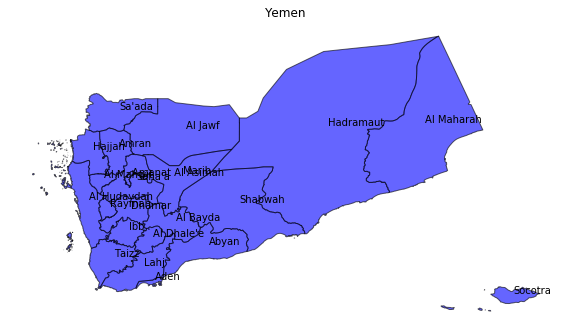

In [35]:
draw_adminstratas("Yemen", AdminStratas["Yemen"], "../Shape Files/shapefiles", figsize = (10, 7), annotation = True)

- **Nigeria**: Nigeria is divided into 36 states. It also includes *The Federal Capital Territory* that is not a state and it is under the direct control of the federal government. The AdminStrata items of the FCS dataframe cover 3 states (Adamawa, Borno and Yobe) and each of these state is diveded into three parts: North, South, Central.

In [36]:
print(AdminStratas["Nigeria"].shape)
AdminStratas["Nigeria"]

(12,)


array(['Adamawa Central', 'Adamawa North', 'Adamawa South',
       'Borno Central', 'Borno North', 'Borno South', 'Yobe East',
       'Yobe North', 'Yobe South', 'Adamawa', 'Borno', 'Yobe'],
      dtype=object)

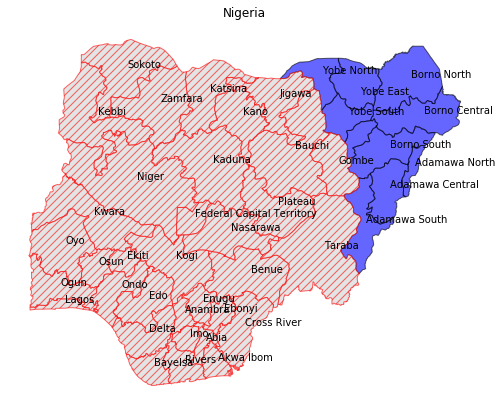

In [37]:
draw_adminstratas("Nigeria", AdminStratas["Nigeria"], "../Shape Files/shapefiles", figsize = (10, 7), annotation = True)

- **Syria**: the governatores of the Syria country are 14. The FCS dataframe has the values of 13 governorates (Idleb governatore not included).

In [38]:
print(AdminStratas["Syria"].shape)
AdminStratas["Syria"]

(13,)


array(['Tartous', 'Al-Hasakeh', 'Aleppo', 'As-Sweida', 'Damascus',
       "Dar'a", 'Hama', 'Homs', 'Lattakia', 'Rural Damascus', 'Ar-Raqqa',
       'Deir-ez-Zor', 'Quneitra'], dtype=object)

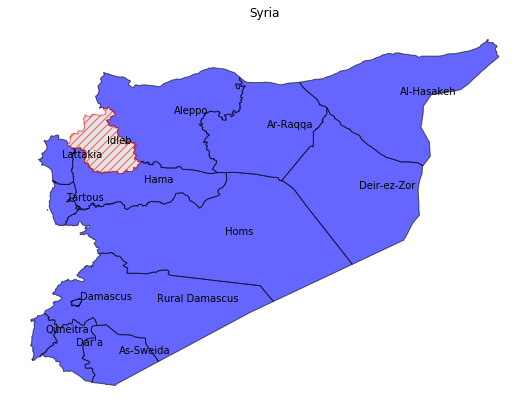

In [39]:
draw_adminstratas("Syria", AdminStratas["Syria"], "../Shape Files/shapefiles", figsize = (10, 7), annotation = True)

- **Burkina Faso**: Burkina Faso is divided into 13 administrative regions. The FCS dataframe has the values of all 13 regions.

In [40]:
print(AdminStratas["Burkina Faso"].shape)
AdminStratas["Burkina Faso"]

(13,)


array(['Boucle-Du-Mouhoun', 'Cascades', 'Centre', 'Centre-Est',
       'Centre-Nord', 'Centre-Ouest', 'Centre-Sud', 'Est',
       'Hauts-Bassins', 'Nord', 'Plateau-Central', 'Sahel', 'Sud-Ouest'],
      dtype=object)

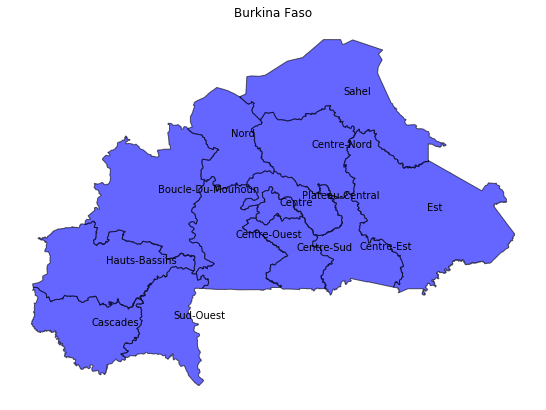

In [41]:
draw_adminstratas("Burkina Faso", AdminStratas["Burkina Faso"], "../Shape Files/shapefiles", figsize = (10, 7), annotation = True)

In [42]:
# Check the min e max values of the Metric.
print("The min and max values of the Metric:")
print(df.Metric.min(), ",", df.Metric.max())

The min and max values of the Metric:
2.24791265253693 , 93.35894621295263


In [43]:
# Creation of an accurate datetime format (not considering the item 'SvyDate').
df.drop(["SvyDate"], axis = 1, inplace = True) 
df["Datetime"] = pd.to_datetime(df["Datetime"])
df.sort_values("Datetime", ascending = True, inplace = True) 
df = df.groupby(["Country", "AdminStrata"]).apply(lambda group: group.set_index("Datetime").resample("D").mean()).reset_index()
df.reset_index(drop = True, inplace = True)
df.head()

,Country,AdminStrata,Datetime,Metric,Pop,PopNmbr
0,Burkina Faso,Boucle-Du-Mouhoun,2019-09-08,30.921705,1976217.0,611079.0
1,Burkina Faso,Boucle-Du-Mouhoun,2019-09-09,31.103928,1976217.0,614681.0
2,Burkina Faso,Boucle-Du-Mouhoun,2019-09-10,32.030296,1976217.0,632988.0
3,Burkina Faso,Boucle-Du-Mouhoun,2019-09-11,32.167300,1976217.0,635695.0
4,Burkina Faso,Boucle-Du-Mouhoun,2019-09-12,31.770045,1976217.0,627845.0


In [44]:
# Create a dataframe with multi-index column in order to have a summary dataframe of the time-series.
df.drop(labels = ["Pop", "PopNmbr"], axis = 1, inplace = True)
df = df.set_index(["Datetime", "Country", "AdminStrata"]).unstack(["Country", "AdminStrata"])
df.columns = df.columns.droplevel(0)
df.columns = pd.MultiIndex.from_tuples(list(map(lambda x: tuple(list(x) + ["FCS"]), df.columns)))
df.columns.rename("Country", level = 0, inplace = True)
df.columns.rename("AdminStrata", level = 1, inplace = True)
df.columns.rename("Indicator", level = 2, inplace = True)
freq = "D"
df.index.freq = freq
df.head()

Country          Burkina Faso                                         \
AdminStrata Boucle-Du-Mouhoun Cascades Centre Centre-Est Centre-Nord   
Indicator                 FCS      FCS    FCS        FCS         FCS   
Datetime                                                               
2018-07-02                NaN      NaN    NaN        NaN         NaN   
2018-07-03                NaN      NaN    NaN        NaN         NaN   
2018-07-04                NaN      NaN    NaN        NaN         NaN   
2018-07-05                NaN      NaN    NaN        NaN         NaN   
2018-07-06                NaN      NaN    NaN        NaN         NaN   

Country                                                     ...      Yemen  \
AdminStrata Centre-Ouest Centre-Sud Est Hauts-Bassins Nord  ...     Hajjah   
Indicator            FCS        FCS FCS           FCS  FCS  ...        FCS   
Datetime                                                    ...              
2018-07-02           NaN        NaN NaN           NaN  NaN  ...  28.361345   
2018-07-03           NaN        NaN NaN           NaN  NaN  ...  28.805448   
2018-07-04           NaN        NaN NaN           NaN  NaN  ...  30.993706   
2018-07-05           NaN        NaN NaN           NaN  NaN  ...  32.905902   
2018-07-06           NaN        NaN NaN           NaN  NaN  ...  32.598181   

Country                                                                        \
AdminStrata        Ibb       Lahj      Marib     Raymah     Sa'ada     Sana'a   
Indicator          FCS        FCS        FCS        FCS        FCS        FCS   
Datetime                                                                        
2018-07-02   25.036668  31.762436  32.596233  54.121774  17.676022  26.917713   
2018-07-03   27.102390  32.049499  33.333333  56.722689  17.134560  25.783476   
2018-07-04   29.844066  33.106267  36.883683  56.306306  17.454545  25.436047   
2018-07-05   29.025363  32.938828  36.897633  56.231003  17.846350  27.421759   
2018-07-06   30.692766  33.837934  36.669568  57.324841  18.463057  26.547231   

Country                                       
AdminStrata    Shabwah    Socotra      Taizz  
Indicator          FCS        FCS        FCS  
Datetime                                      
2018-07-02   16.752289  23.822825  26.563365  
2018-07-03   18.257453  23.699881  29.124005  
2018-07-04   19.083081  23.103187  29.427973  
2018-07-05   20.349533  21.596419  30.456026  
2018-07-06   21.107524  20.129084  31.012517  

[5 rows x 60 columns]

In [46]:
# Plot time-series.
TsIP(df).interactive_plot_df(matplotlib = False, style = "lines", yaxis = "% of people with poor and borderline FCS", 
                             first_last_valid_index_group = True)

interactive(children=(ToggleButtons(description='Country', options=('Burkina Faso', 'Nigeria', 'Syria', 'Yemen…

**ATTENTION**: the adminstratas *Hadramaut* and *Socotra* of the Yemen country have exactly the same time-series for the FCS indicator! I decide to delete the time-series of the *Socotra* adminstrata and considering only that of *Hadramaut* province as union of these two provinces. 

In [47]:
df = df.drop("Socotra", axis = 1, level = 1)

In [48]:
# Now save the time-series of each country keeping as indeces for each time-series the own first and last index.
def save(group, name):
    country = group.name
    group = group[country]
    # Adjust time-series group.
    first_idx = group.first_valid_index()
    last_idx = group.last_valid_index()
    group = group.loc[first_idx:last_idx]
    # Save.
    group.to_csv(PATH_TO_SAVE_DATA + country + "/" + name + ".csv", index_label = False)

In [49]:
df.groupby(level = 0, axis = 1).apply(lambda x: save(x, name = "wfp_fcs"));

## Adjusting the time-series (interpolation nan values)

Let's interpolate the nan values using a linear interpolation up to a limit of 7 days. Moreover, we delete the time-series that still have some nan values inside them.

In [61]:
# Let's interpolate the nan values using a linear interpolation up to a limit of 7 days.
def interpolation(group):   
    group.columns = group.columns.droplevel()
    first_idx = group.first_valid_index()
    last_idx = group.last_valid_index()
    group = group.loc[first_idx:last_idx]
    group = group.interpolate(method = "linear", limit = 7)
    # Delete time-series that still have some NaN values.
    group.dropna(inplace = True, axis = 1)
    return group

df_interpolate = df.groupby(axis = 1, level = 0).apply(interpolation)
df_interpolate.head()

Country          Burkina Faso                                         \
AdminStrata Boucle-Du-Mouhoun Cascades Centre Centre-Est Centre-Nord   
Indicator                 FCS      FCS    FCS        FCS         FCS   
Datetime                                                               
2018-07-02                NaN      NaN    NaN        NaN         NaN   
2018-07-03                NaN      NaN    NaN        NaN         NaN   
2018-07-04                NaN      NaN    NaN        NaN         NaN   
2018-07-05                NaN      NaN    NaN        NaN         NaN   
2018-07-06                NaN      NaN    NaN        NaN         NaN   

Country                                                     ...      Yemen  \
AdminStrata Centre-Ouest Centre-Sud Est Hauts-Bassins Nord  ...  Hadramaut   
Indicator            FCS        FCS FCS           FCS  FCS  ...        FCS   
Datetime                                                    ...              
2018-07-02           NaN        NaN NaN           NaN  NaN  ...  23.822825   
2018-07-03           NaN        NaN NaN           NaN  NaN  ...  23.699881   
2018-07-04           NaN        NaN NaN           NaN  NaN  ...  23.103187   
2018-07-05           NaN        NaN NaN           NaN  NaN  ...  21.596419   
2018-07-06           NaN        NaN NaN           NaN  NaN  ...  20.129084   

Country                                                                        \
AdminStrata     Hajjah        Ibb       Lahj      Marib     Raymah     Sa'ada   
Indicator          FCS        FCS        FCS        FCS        FCS        FCS   
Datetime                                                                        
2018-07-02   28.361345  25.036668  31.762436  32.596233  54.121774  17.676022   
2018-07-03   28.805448  27.102390  32.049499  33.333333  56.722689  17.134560   
2018-07-04   30.993706  29.844066  33.106267  36.883683  56.306306  17.454545   
2018-07-05   32.905902  29.025363  32.938828  36.897633  56.231003  17.846350   
2018-07-06   32.598181  30.692766  33.837934  36.669568  57.324841  18.463057   

Country                                       
AdminStrata     Sana'a    Shabwah      Taizz  
Indicator          FCS        FCS        FCS  
Datetime                                      
2018-07-02   26.917713  16.752289  26.563365  
2018-07-03   25.783476  18.257453  29.124005  
2018-07-04   25.436047  19.083081  29.427973  
2018-07-05   27.421759  20.349533  30.456026  
2018-07-06   26.547231  21.107524  31.012517  

[5 rows x 44 columns]

In [62]:
# Plot time-series.
TsIP(df_interpolate).interactive_plot_df(matplotlib = False, style = "lines", yaxis = "% of people with poor and borderline FCS", 
                                         first_last_valid_index_group = True)

interactive(children=(ToggleButtons(description='Country', options=('Burkina Faso', 'Syria', 'Yemen'), value='…

In [63]:
# Save these new time-series.
df_interpolate.groupby(level = 0, axis = 1).apply(lambda x: save(x, name = "wfp_fcs-no-nan"));